# 文本分类-20 newsgroups

In [1]:
# 准备好所需要的工具
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np

# 数据探索

In [2]:
# 从20个分类中挑选4个进行训练
categories = ['talk.politics.guns', 'rec.motorcycles', 'comp.graphics', 'sci.space']

探索每个分类的数据分布情况

In [3]:
category_numbers = []
for category in categories:
    numbers = len(fetch_20newsgroups(subset='train', categories=[category]).target)
    category_numbers.append(numbers)
print (category_numbers)

[546, 598, 584, 593]


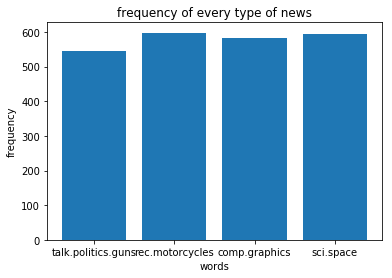

In [4]:
import matplotlib.pyplot as plt

plt.bar(range(len(categories)) ,category_numbers)
plt.xlabel('words')
plt.ylabel('frequency')
plt.xticks(range(len(categories)),categories)
plt.title('frequency of every type of news')
plt.show()

In [5]:
# 文本内容例子
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_train.data[1]

'Subject: Re: Shaft-drives and Wheelies\nFrom: Stafford@Vax2.Winona.MSUS.Edu (John Stafford)\nDistribution: world\nOrganization: Winona State University\nNntp-Posting-Host: stafford.winona.msus.edu\nLines: 19\n\nIn article <1r16ja$dpa@news.ysu.edu>, ak296@yfn.ysu.edu (John R. Daker)\nwrote:\n> \n> \n> In a previous article, xlyx@vax5.cit.cornell.edu () says:\n> \n> Mike Terry asks:\n> \n> >Is it possible to do a "wheelie" on a motorcycle with shaft-drive?\n> >\n> No Mike.  It is imposible due to the shaft effect.  The centripital effects\n> of the rotating shaft counteract any tendency for the front wheel to lift\n> off the ground.\n\n\tThis is true as evinced by the popularity of shaft-drive drag bikes.\n\n====================================================\nJohn Stafford   Minnesota State University @ Winona\n                    All standard disclaimers apply.\n'

文档中的频率最高几个单词

In [6]:
# 将data list中的文本去掉符号并合成一个，为了统计单词频率
import re
str = []
for i in range(len(newsgroups_train.data)):
    #s = re.sub(r'[^\w\s]','',newsgroups_train.data[i]).split(' ')
    str.extend(newsgroups_train.data[i].split(' '))

In [7]:
from collections import Counter
c = Counter(str)
# 计算次数最多的前10个
most_common = c.most_common(10) 
print (most_common)

[('', 123483), ('the', 21759), ('to', 12076), ('of', 11983), ('a', 11183), ('and', 9173), ('in', 6582), ('is', 6404), ('I', 5633), ('that', 5173)]


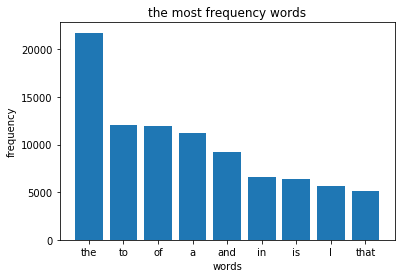

In [8]:
# 显示频率最高的9个词
x_word = []
x_time = range(0,9)
y_num = []
for item in most_common[1:]:
    x_word.append(item[0])
    y_num.append(item[1])

import matplotlib.pyplot as plt
plt.bar(x_time ,y_num)

plt.xlabel('words')
plt.ylabel('frequency')
plt.xticks(x_time,x_word)
plt.title('the most frequency words')
plt.show()

可以看出数据中大部分都是没有携带信息的常规单词如定冠词the,介词of等，这对于建立模型并没有好处，因此我们需要提取重要信息的单词。可以使用TF-IDF方法

# 提取特征

这个函数用于去掉文本中的符号等信息,并转化为小写

In [9]:
import re
def preprocessor(text):
    text = re.sub('[\W]+', ' ', text.lower()) 
    return text

文本中的单词不适合做特征，所以需要转化。下面我使用TF-IDF的方法进行表征。

In [10]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor, stop_words='english', min_df=0.001)
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
X_train = vectorizer.fit_transform(newsgroups_train.data)

newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
X_test = vectorizer.transform(newsgroups_test.data) 

In [41]:
print(X_train.shape)

(2321, 13315)


# 算法：

### 1.MultinomialNB

In [11]:
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB(alpha=0.2)
clf_NB.fit(X_train, newsgroups_train.target)
pred = clf_NB.predict(X_test)
accuracy_score(newsgroups_test.target, pred)

0.96440129449838186

### 2.SVC

In [52]:
from sklearn.svm import SVC
clf_svc = SVC(kernel='linear', random_state = 3)#default with 'rbf'
clf_svc.fit(X_train, newsgroups_train.target)
pred_svc = clf_svc.predict(X_test)
accuracy_score(newsgroups_test.target, pred_svc)

0.96440129449838186

### 3.深度学习

In [71]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import EarlyStopping

X_train_nn = X_train.toarray()
X_test_nn = X_test.toarray()

# one-hot target
lb = LabelBinarizer()
y_train = lb.fit_transform(newsgroups_train.target)
y_test = lb.fit_transform(newsgroups_test.target)
# 使用early_stop，当精度不再提高的时候停止迭代
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0)

Using TensorFlow backend.


In [76]:
# 神经网络
def gen_nn(input_dim=800, width=32):
    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=width))
    model.add(Activation('relu'))
    model.add(Dense(output_dim=width))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim=4))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = gen_nn(input_dim=X_train_nn.shape[1])
his = model.fit(X_train_nn, y_train, nb_epoch=800, \
                      batch_size=24, \
                      validation_split=0.2, \
                      shuffle=True, verbose=1, \
                      callbacks=[early_stop] )
# 测试的精度
score = model.evaluate(X_test_nn, y_test, verbose=0)


Train on 1856 samples, validate on 465 samples
Epoch 1/800
1856/1856 [==============================] - 1s - loss: 1.2963 - acc: 0.7144 - val_loss: 1.1519 - val_acc: 0.9634

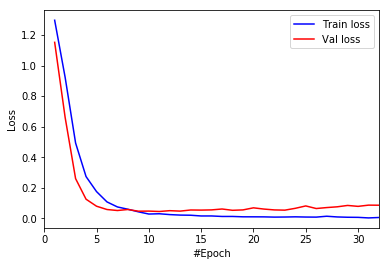

[0.13127491120446827, 0.97022653725540753]


In [77]:
# 可视化结果

train_loss = his.history['loss']
val_loss = his.history['val_loss']

plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
plt.xlim(0, len(train_loss))
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('fig-nn-val-earlystop.png', dpi=300)
plt.show()
# 打印测试精度
print(score)

# 总结

三个算法的精度都到了0.96以上，比之前例子(基准)0.88高了0.8，表现还不错。接下来看看其中MultinomialNB给出的一个结果，对于主题重要意义的单词（权重大的）

In [15]:
import bottleneck as bn
weight_NB = clf_NB.coef_[3]
most_largest_weight_index = bn.argpartsort(-weight_NB, 10)[:10] 
words_dic = vectorizer.vocabulary_ 
for index in most_largest_weight_index:
    for key,value in words_dic.items():
        if value == index:
            vk = key
            print(key)

people
edu
com
gun
guns
stratus
fbi
batf
don
weapons


从上可以看出，'talk.politics.guns'这个分类也是比较准确如有people,gun,fbi,weapons等与枪主题相关的词汇。但是这也展示了我们提高的方向，如单复数的处理等单词形式的处理